In [77]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from scipy.special import boxcox, inv_boxcox
import seaborn as sns
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
data = pd.read_csv('WAG_C_M.csv',sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [38]:
data.head()

,WAG_C_M,salary_box,salary_dif12,salary_dif1
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN


Text(0, 0.5, 'average salary per year')

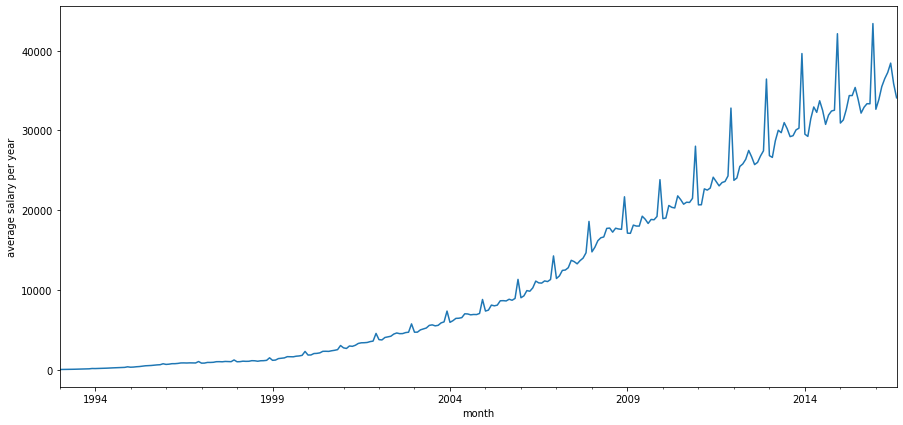

In [19]:
plt.figure(figsize=(15,7))
data.WAG_C_M.plot();
plt.ylabel('average salary per year')

В ряде видны следующие проблемы визуально:
- нарастающий тренд
- годовая сезонность
- увеличение дисперсии со временем

Проверим ряд на стационарность формальным критерием и проведем SLT-декомпозицию

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

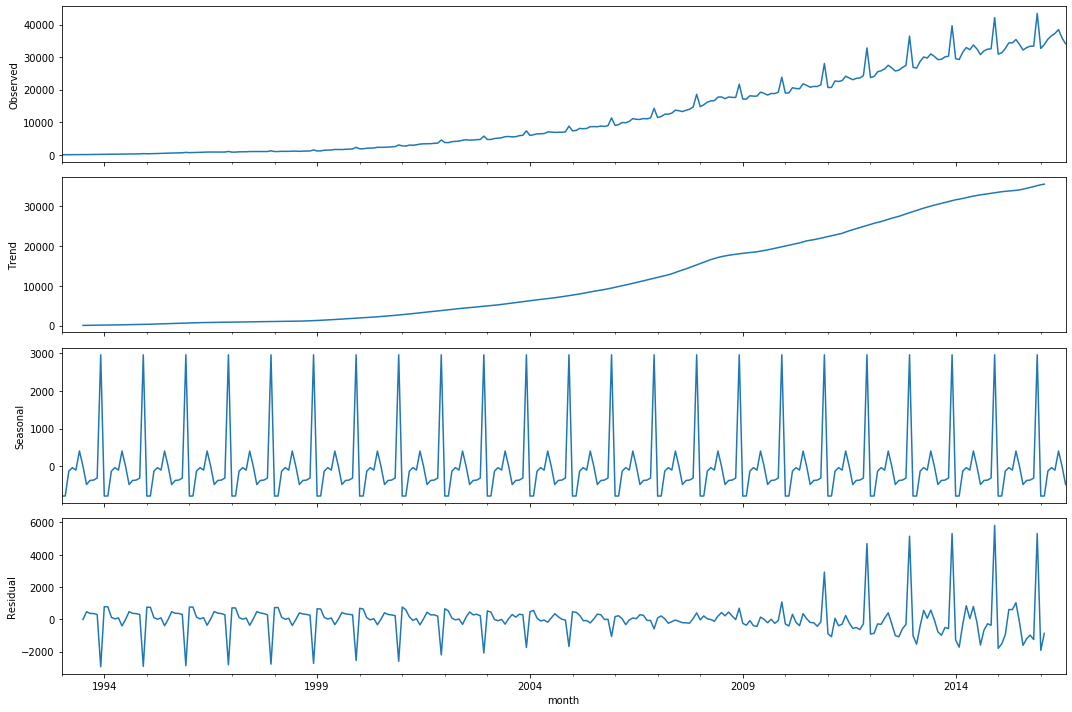

In [25]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Гипотеза о нестационарности ряда не может быть отвергнута. На декомпозиции видно все компоненты, что были описаны ранее, также видно что остатки не похожи на шум

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


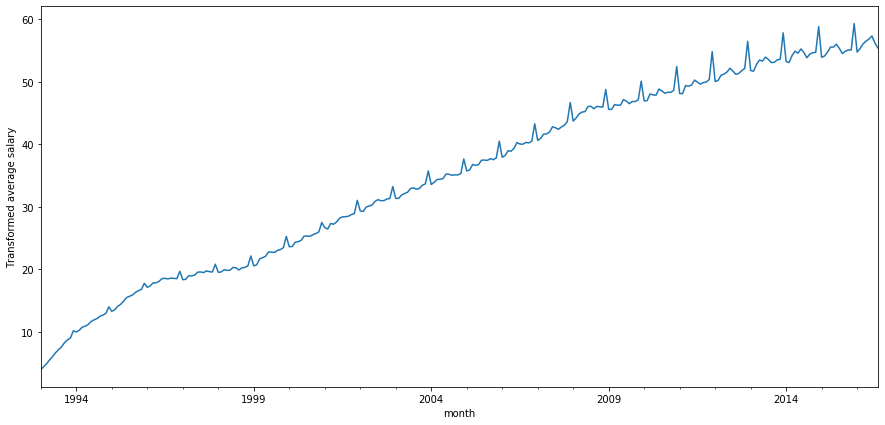

In [27]:
data['salary_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed average salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

Дисперсия стала меньше, по прежнему видно тренд и годовую сезонность, будем дальше дифференцировать ряд, сначала по сезонности и проведем декомпозицию SLT на полученных результатах

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

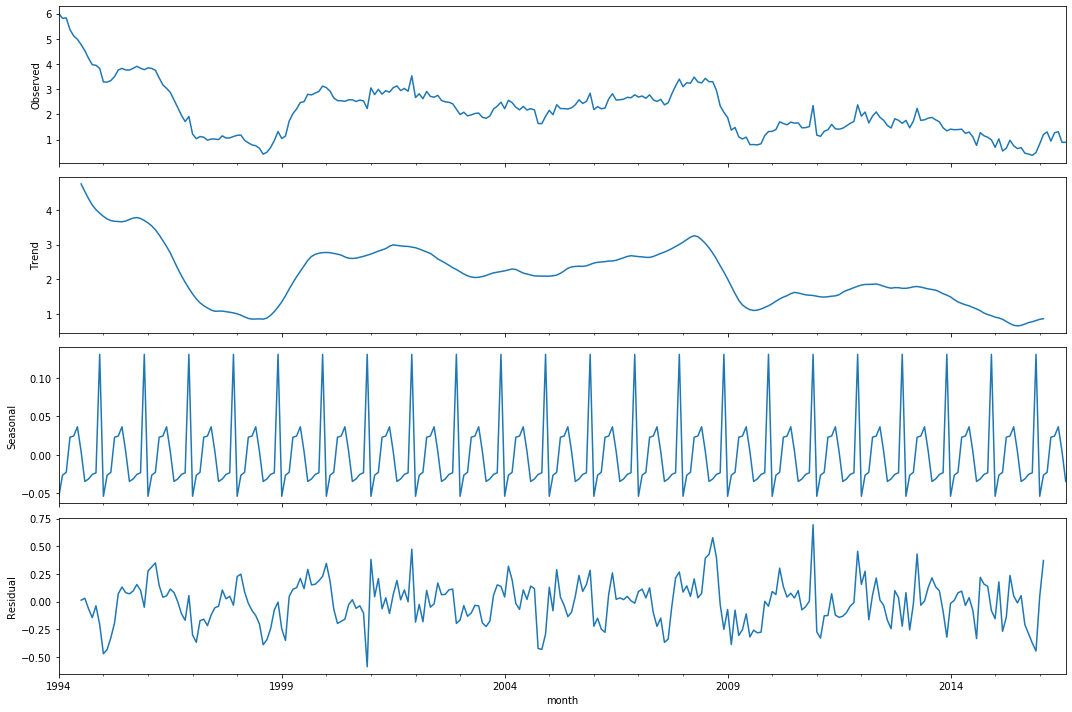

In [30]:
data['salary_dif12'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_dif12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_dif12[12:])[1])

Хоть критерий Дики-Фулера и отвергает гипотезу нестационарности видно, что частично тренд сохраняется, сделаем дифференцирование на 1

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

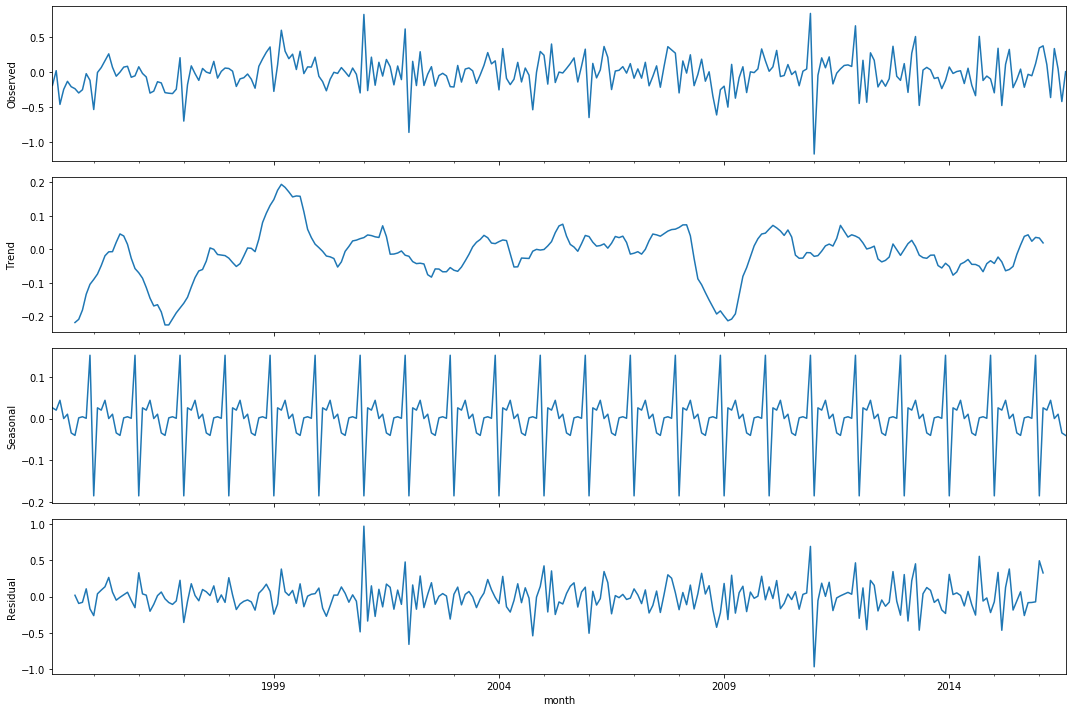

In [33]:
data['salary_dif1'] = data.salary_dif12 - data.salary_dif12.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_dif1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_dif1[13:])[1])

Теперь видно, что в данных нет трендовой составляющей и нестационарность ряда уверенно отвергается с очень низким достигаемым уровнем значимости

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

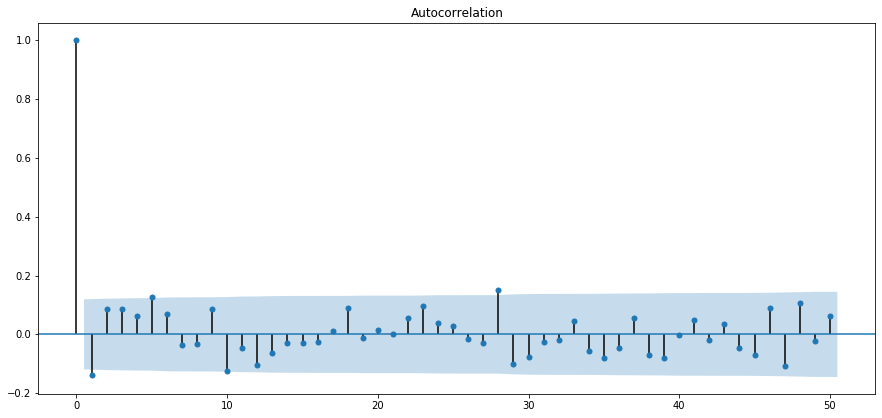

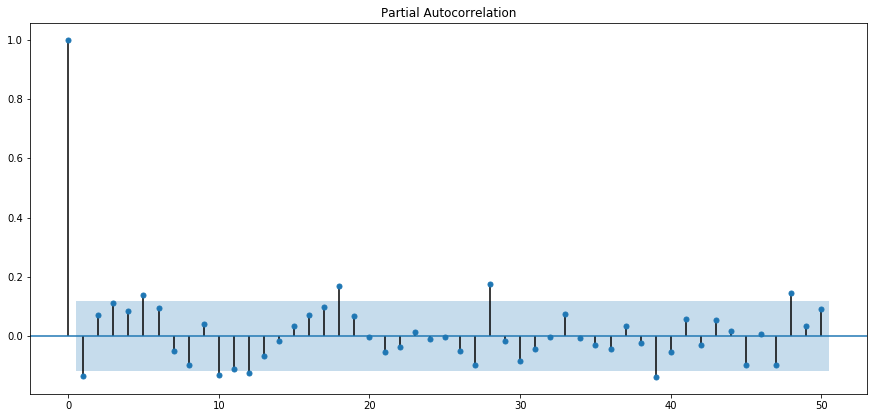

In [40]:
plt.figure(figsize(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_dif1[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_dif1[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

 Начальные приближения:
 - Q = 0. Выбор основан на том, что на графике автокорреляции нет ни одного значимого сезонного лага
 - q = 5. Значимый несезенноый лаг на графики автокорреляции, неслишком большой как 28. Возможно лучше было брать 1 
 - P = 4. Последний сезонный значимый лаг 48, то есть 4 в пересчете на сезонность на графике частичной автокрреляции
 - p = 5. Последний значимый не сезонный лаг, не слишком большой на графике частичной автокорреляции
 
 Установим начальные приближения в соотвествии с выбранными значениями

In [91]:
ps = list(range(0,6))
d=1
qs = list(range(0,6))
Ps = list(range(0,5))
D=1
Qs = list(range(0, 1))

In [92]:
ps

[0, 1, 2, 3, 4, 5]

In [93]:
parameters = itertools.product(ps,qs,Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [95]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 2, 2, 0)
wrong parameters: (4, 2, 1, 0)
CPU times: user 29min 10s, sys: 9.86 s, total: 29min 20s
Wall time: 7min 43s


In [96]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
174  (5, 5, 1, 0) -25.089894
144  (4, 5, 1, 0) -24.024032
175  (5, 5, 2, 0) -23.415656
145  (4, 5, 2, 0) -22.606557
173  (5, 5, 0, 0) -21.855039


In [97]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.545
Date:                            Thu, 26 Mar 2020   AIC                            -25.090
Time:                                    16:44:56   BIC                             18.136
Sample:                                01-01-1993   HQIC                            -7.734
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2255      7.105     -0.032      0.975     -14.152      13.701
ar.L2          0.2309      5.049   

Посмотрим на остатки модели

Критерий Стьюдента: p=0.169131
Критерий Дики-Фуллера: p=0.000000


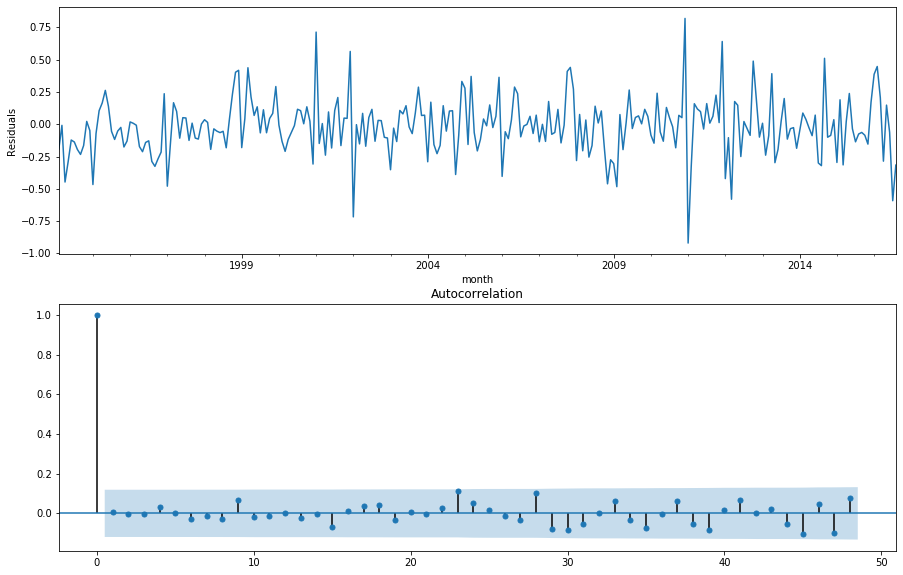

In [98]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Проверяем критерии:

- Критерией Стьюдента: p = 0.169 > 0.05 - остатки несмещены
- Критерий Дики-Фуллера: p < 0.05 - остатки стационарны
- Критерий Льюнга-Бокса: p = 0.96 > 0.05 - остатки неавтокоррелированы

Посмотрим, насколько хорошо модель описывает данные:

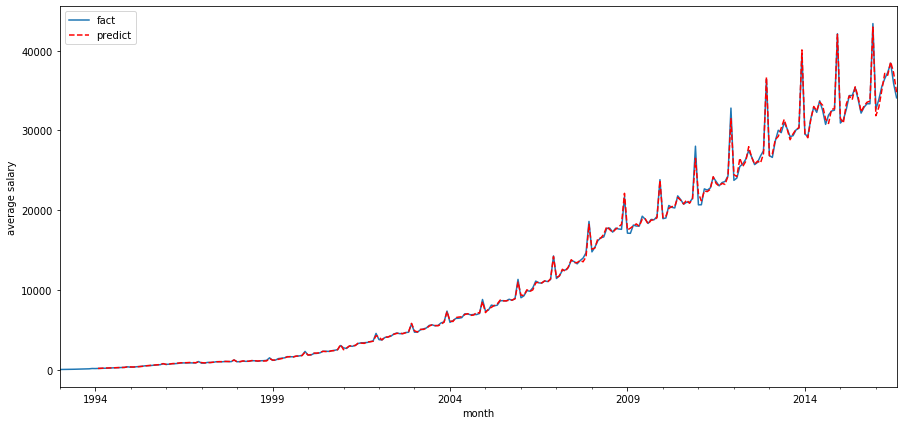

In [101]:
data['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot(label = 'fact')
data.model[13:].plot(color='r', label = 'predict', linestyle = '--')
plt.ylabel('average salary')
plt.legend()
pylab.show()

модель очень неплохо приближает данные, посмотрим на прогноз

### Прогноз

In [118]:
best_model.predict(start=287, end=287 + 36)

2016-12-01    59.966361
2017-01-01    55.111040
2017-02-01    55.575851
2017-03-01    56.174363
2017-04-01    56.565384
2017-05-01    56.966188
2017-06-01    57.514251
2017-07-01    56.465953
2017-08-01    55.788396
2017-09-01    56.266172
2017-10-01    56.376931
2017-11-01    56.399283
2017-12-01    60.413724
2018-01-01    55.509618
2018-02-01    55.985742
2018-03-01    56.629606
2018-04-01    56.958640
2018-05-01    57.347833
2018-06-01    57.940778
2018-07-01    56.849600
2018-08-01    56.150070
2018-09-01    56.676882
2018-10-01    56.772271
2018-11-01    56.768347
2018-12-01    60.819077
2019-01-01    55.906673
2019-02-01    56.349234
2019-03-01    57.020430
2019-04-01    57.353891
2019-05-01    57.710817
2019-06-01    58.324153
2019-07-01    57.246835
2019-08-01    56.519384
2019-09-01    57.058260
2019-10-01    57.171530
2019-11-01    57.143530
2019-12-01    61.198721
Freq: MS, dtype: float64

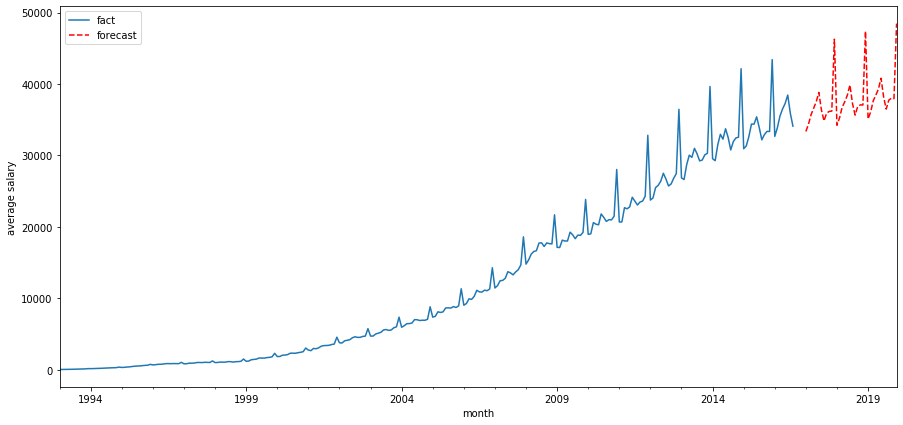

In [119]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2017-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = inv_boxcox(best_model.predict(start=287, end=287 + 36), lmbda)

plt.figure(figsize(15,7))
data.WAG_C_M.plot(label = 'fact')
data2.forecast.plot(color='r', label = 'forecast', linestyle = '--')
plt.ylabel('average salary')
plt.legend()
pylab.show()